In [1]:
import os
import shutil
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras import models, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split

In [2]:
seed = 69
tf.random.set_seed(seed)
np.random.seed(seed)
sample_rate = 16000

data_dir = 'data/combined_normalized'
classes = np.array(os.listdir(data_dir))
num_classes = len(classes)

classes_index = {label: index for index, label in enumerate(classes)}
print('Classes:', classes_index)

filenames = tf.io.gfile.glob(data_dir + '/*/*')
labels = [classes_index[f.split(os.path.sep)[-2]] for f in filenames]
num_samples = len(filenames)
print('Number of total examples:', num_samples)

x_train, x_val, y_train, y_val = train_test_split(filenames, labels, test_size=0.2, random_state=seed, shuffle=True, stratify=labels)

print('Train:', len(x_train))
print(collections.Counter(y_train))
print('Val:', len(x_val))
print(collections.Counter(y_val))

Classes: {'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4}
Number of total examples: 9531
Train: 7624
Counter({0: 1603, 2: 1559, 1: 1557, 4: 1552, 3: 1353})
Val: 1907
Counter({0: 401, 2: 390, 1: 389, 4: 388, 3: 339})


(224, 224, 1)


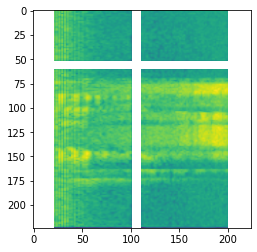

In [3]:
wav = tf.io.read_file(x_train[0])
wav, sr = tf.audio.decode_wav(wav, desired_channels=1)
wav = tf.squeeze(wav, axis=-1)
sr = tf.cast(sr, dtype=tf.int64)
wav = tfio.audio.resample(wav, rate_in=sr, rate_out=sample_rate)
spectrogram = tfio.audio.spectrogram(wav, nfft=512, window=512, stride=256)
mel_spectrogram = tfio.audio.melscale(spectrogram, rate=sample_rate, mels=128, fmin=80, fmax=7600)
mel_spectrogram = tfio.audio.freq_mask(mel_spectrogram, param=10)
mel_spectrogram = tfio.audio.time_mask(mel_spectrogram, param=10)
mel_spectrogram = tf.expand_dims(mel_spectrogram, axis=-1)
mel_spectrogram = tf.image.resize_with_pad(mel_spectrogram, target_height=224, target_width=224, method=tf.image.ResizeMethod.BILINEAR)
plt.figure()
plt.imshow(tf.math.log(mel_spectrogram).numpy())
print(mel_spectrogram.shape)

In [4]:
@tf.function(jit_compile=False)
def preprocess(filepath):
      wav = tf.io.read_file(filepath)
      wav, sr = tf.audio.decode_wav(wav, desired_channels=1)
      wav = tf.squeeze(wav, axis=-1)
      sr = tf.cast(sr, dtype=tf.int64)
      wav = tfio.audio.resample(wav, rate_in=sr, rate_out=sample_rate)
      spectrogram = tfio.audio.spectrogram(wav, nfft=512, window=512, stride=256)
      mel_spectrogram = tfio.audio.melscale(spectrogram, rate=sample_rate, mels=128, fmin=80, fmax=7600)

      # Augmentations
      mel_spectrogram = tfio.audio.freq_mask(mel_spectrogram, param=10)
      mel_spectrogram = tfio.audio.time_mask(mel_spectrogram, param=10)

      # Resizing
      mel_spectrogram = tf.expand_dims(mel_spectrogram, axis=-1)
      mel_spectrogram = tf.image.resize_with_pad(mel_spectrogram, target_height=224, target_width=224, method=tf.image.ResizeMethod.BILINEAR)  # any sharper resizing method produce black gaps
      mel_spectrogram = tf.squeeze(tf.stack([mel_spectrogram, mel_spectrogram, mel_spectrogram], axis=-1))
      mel_spectrogram.set_shape([224, 224, 3])
      return mel_spectrogram, tf.argmax(tf.strings.split(filepath, os.path.sep)[-2] == classes)


train_ds = tf.data.Dataset.from_tensor_slices(x_train).map(preprocess, num_parallel_calls=-1)
val_ds = tf.data.Dataset.from_tensor_slices(x_val).map(preprocess, num_parallel_calls=-1)

batch_size = 16
train_ds = train_ds.batch(batch_size).cache().prefetch(-1)
val_ds = val_ds.batch(batch_size).cache().prefetch(-1)

In [9]:
# test data
c = 0
for i in x_train:
      try:
            wav = tf.io.read_file(os.path.abspath(i))
            wav, sr = tf.audio.decode_wav(wav, desired_channels=1)
      except Exception as e:
            c += 1
            shutil.move(i, os.path.abspath(os.path.join(data_dir, 'bad_files/', i.split(os.path.sep)[-1])))

for i in x_val:
      try:
            wav = tf.io.read_file(os.path.abspath(i))
            wav, sr = tf.audio.decode_wav(wav, desired_channels=1)
      except Exception as e:
            c += 1
            shutil.move(i, os.path.abspath(os.path.join(data_dir, 'bad_files/', i.split(os.path.sep)[-1])))

c

0

In [5]:
# Training
# NO preprocessing needed! Already scaled
xInput = Input((224, 224, 3))
densenet121 = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet', input_tensor=xInput)
x = densenet121(xInput)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='swish')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='swish')(x)
xOutput = Dense(len(classes))(x)  # no activation as loss using logit=True
model = tf.keras.models.Model(xInput, xOutput)

In [6]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']
epoch = 20
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=6, verbose=1,
                                     mode='auto', baseline=None, restore_best_weights=True),
    # tf.keras.callbacks.ModelCheckpoint('./best_model',monitor='val_accuracy',save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=4, verbose=1)
]
model.compile(optimizer=opt, loss=loss, metrics=metrics)
plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, to_file='model.png') # SC1_ensemble.png
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dropout (Dropout)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 256)               12845312  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792 

In [7]:
history = model.fit(train_ds, epochs=epoch, validation_data=val_ds, callbacks=callbacks, use_multiprocessing=True, verbose=1)

Epoch 1/20
477/477 [==============================] - 49s 82ms/step - loss: 2.2254 - accuracy: 0.2678 - val_loss: 1.9393 - val_accuracy: 0.3781 - lr: 0.0010
Epoch 2/20
477/477 [==============================] - 34s 71ms/step - loss: 1.4771 - accuracy: 0.3235 - val_loss: 1.3667 - val_accuracy: 0.3949 - lr: 0.0010
Epoch 3/20
477/477 [==============================] - 35s 73ms/step - loss: 1.4497 - accuracy: 0.3384 - val_loss: 1.3485 - val_accuracy: 0.4174 - lr: 0.0010
Epoch 4/20
477/477 [==============================] - 35s 73ms/step - loss: 1.4387 - accuracy: 0.3555 - val_loss: 1.5085 - val_accuracy: 0.3026 - lr: 0.0010
Epoch 5/20
477/477 [==============================] - 34s 71ms/step - loss: 1.3665 - accuracy: 0.3947 - val_loss: 1.2740 - val_accuracy: 0.4504 - lr: 0.0010
Epoch 6/20
477/477 [==============================] - 34s 72ms/step - loss: 1.3212 - accuracy: 0.4189 - val_loss: 1.2991 - val_accuracy: 0.4683 - lr: 0.0010
Epoch 7/20
477/477 [==============================] - 35s 